### 1. LeNet5 Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import numpy as np

class ScaledTanh(nn.Module):
    def forward(self, x):
        return 1.7159 * torch.tanh(x * 2 / 3)
    
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.tanh = ScaledTanh()

        # C1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        
        # S2
        self.weight2 = nn.Parameter(torch.ones(1, 6, 1, 1))
        self.bias2 = nn.Parameter(torch.zeros(1, 6, 1, 1))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight2)
        nn.init.uniform_(self.weight2, -2.4 / fan_in, 2.4 / fan_in)
        self.bias2.data.fill_(2.4 / fan_in)

        # C3
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        mask = torch.zeros_like(self.conv3.weight, dtype=torch.bool)
        table = self.connection_table()
        for out_idx, conn in enumerate(table):
            mask[out_idx, conn] = True
        self.register_buffer("conv3_mask", mask.float())
        with torch.no_grad():
            self.conv3.weight *= self.conv3_mask
        # self.weight3 = nn.Parameter(torch.Tensor(16, 6, 5, 5))
        # self.bias3 = nn.Parameter(torch.Tensor(1, 16, 1, 1))  # Shape [16] instead of [1, 16, 1, 1]
        # fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight3)
        # nn.init.uniform_(self.weight3, -2.4 / fan_in, 2.4 / fan_in)
        # self.bias3.data.fill_(2.4 / fan_in)

        # S4
        self.weight4 = nn.Parameter(torch.ones(1, 16, 1, 1))
        self.bias4 = nn.Parameter(torch.zeros(1, 16, 1, 1))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight4)
        nn.init.uniform_(self.weight4, -2.4 / fan_in, 2.4 / fan_in)
        self.bias4.data.fill_(2.4 / fan_in)

        # C5
        self.conv5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)

        # F6
        self.fc6 = nn.Linear(120, 84)

        # Output Layer
        self.prototypes = self.compute_rbf_prototypes()
        # self.output = nn.Linear(10, 84)

    def connection_table(self):
        return [
            [0, 1, 2],
            [1, 2, 3],
            [2, 3, 4],
            [3, 4, 5],
            [0, 4, 5],
            [0, 1, 5],
            [0, 1, 2, 3],
            [1, 2, 3, 4],
            [2, 3, 4, 5],
            [0, 3, 4, 5],
            [0, 1, 4, 5],
            [0, 1, 2, 5],
            [0, 1, 3, 4],
            [1, 2, 4, 5],
            [1, 2, 3, 5],
            [0, 1, 2, 3, 4, 5]
        ]

    def compute_rbf_prototypes(self):
        import matplotlib.pyplot as plt

        prototypes = []

        image_folder = './digits updated/'
        bitmap_size = (7,12)
        num_classes = 10

        for label in range(num_classes):
            class_folder = os.path.join(image_folder, str(label))
            images = []
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                image = cv2.imread(img_path, 0)
                if image is not None:
                    image = cv2.resize(image, bitmap_size)
                    image = 255.0 - image  # Invert colors
                    image = (image > 127).astype(np.float32)  # Binarize to 0 and 1
                    image = image / 255.0
                    # print(image)
                    # plt.imshow(image, cmap='gray')
                    # plt.title("Image for digit "+ str(label))
                    # plt.colorbar()
                    # plt.show()
                    images.append(image)
            if images:
                mean_image = np.mean(images, axis=0)
                # mean_image = np.mean(images, axis=0) / 255.0  # Normalize grayscale to [0, 1]
                prototypes.append(mean_image.flatten())



        prototypes_arr = np.array(prototypes)
        # for i in range(prototypes_arr.shape[0]):

            # proto = prototypes_arr[i].reshape(12, 7)
            # plt.imshow(proto, cmap='gray')
            # plt.title("Prototype for digit "+ str(i))
            # plt.colorbar()
            # plt.show()
        # print("Prototypes Array Sample (Before Return):")
        # print(prototypes_arr[:5])  # Print the first 5 prototypes for debugging
        # print("Prototypes Mean/Std:", prototypes_arr.mean(), prototypes_arr.std())  # Check mean and std

        return torch.tensor(prototypes_arr, dtype=torch.float32)

    def compute_rbf_distance(self, x):
        x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-5)
        prototypes = (self.prototypes - self.prototypes.mean(dim=1, keepdim=True)) / (self.prototypes.std(dim=1, keepdim=True) + 1e-5)

        # L2 normalize input features and prototypes
        x = F.normalize(x, p=2, dim=1)  # shape: [batch_size, feature_dim]
        prototypes = F.normalize(prototypes, p=2, dim=1)  # shape: [num_classes, feature_dim]

        # Compute pairwise squared Euclidean distances
        x_expanded = x.unsqueeze(1)  # shape: [batch_size, 1, feature_dim]
        prototypes_expanded = prototypes.unsqueeze(0)  # shape: [1, num_classes, feature_dim]
        output = (x_expanded - prototypes_expanded).pow(2).sum(-1)  # shape: [batch_size, num_classes]

        # Debug info
        # print("RBF distances (min/max):", output.min().item(), output.max().item())
        # print("RBF distances:", output[0])  # print one example

        return output
        # x_expanded = x.unsqueeze(1).expand((x.size(0), self.prototypes.size(0), self.prototypes.size(1)))  
        # params_expanded = self.prototypes.unsqueeze(0).expand((x.size(0), self.prototypes.size(0), self.prototypes.size(1)))         
        # output = (x_expanded - params_expanded).pow(2).sum(-1)

        # print("RBF distances (min/max):", output.min().item(), output.max().item())
        # print("RBF distances:", output[0])  # print only first example for readability
    
        # return output    

    def forward(self, x):
        # C1
        x = self.conv1(x)
        x = self.tanh(x)

        # S2
        x = F.avg_pool2d(x, kernel_size=2, stride=2) * self.weight2.view(1, -1, 1, 1) + self.bias2.view(1, -1, 1, 1)
        x = self.tanh(x)

        # C3
        self.conv3.weight.data *= self.conv3_mask  # Apply the mask to the weights
        x = self.conv3(x)
        x = self.tanh(x)

        # print("conv3 weights sample:", self.conv3.weight[0, :3, 2:4, 2:4])
        # print("conv3 mask sample:", self.conv3_mask[0, :3, 2:4, 2:4])

        # batch_size = x.size(0)
        # output = torch.zeros(batch_size, 16, x.size(2) - 5 + 1, x.size(3) - 5 + 1).to(x.device)
        # for i in range(16):  # For each output channel
        #     connected_channels = self.connection_table()[i]
        #     for j, input_channel in enumerate(connected_channels): # input channels 0-5
        #         input_slice = x[:, input_channel, :, :].unsqueeze(1)  # Select the input channel and add batch dimension
                
        #         # Create the weight tensor for the convolution (shape: [1, 1, 5, 5])
        #         weight = self.weight3[i, j, :, :].unsqueeze(0).unsqueeze(0)
                
        #         # Perform convolution (output will have shape [batch_size, 1, height, width])
        #         conv_output = F.conv2d(input_slice, weight)
                
        #         # print(conv_output.shape)
                
        #         # Accumulate results in the correct output channel
        #         output[:, i:i+1, :, :] += conv_output
        #         # print(output.shape)

        # bias = self.bias3.view(16)  # shape: [16]
        # for i in range(16):
        #     output[:, i:i+1, :, :] += bias[i]
        # # print(output.shape)
        # x = output
        # x = self.tanh(x)

        # S4
        x = F.avg_pool2d(x, kernel_size=2, stride=2) * self.weight4.view(1, -1, 1, 1) + self.bias4.view(1, -1, 1, 1)
        x = self.tanh(x)

        # C5
        x = self.conv5(x)
        x = self.tanh(x)

        # F6
        x = x.view(x.size(0), -1)
        x = self.fc6(x)
        # print("fc6 output (sample):", x[0][:10])
        # print("Prototype[0] (sample):", self.prototypes[0][:10])
        # print("Feature mean/std:", x.mean().item(), x.std().item())
        # print("Prototype mean/std:", self.prototypes.mean().item(), self.prototypes.std().item())
        # Output Layer
        x = self.compute_rbf_distance(x)
        # x = self.output(x)
        return x

### 2. Load Train and Test Data

In [2]:
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
train_image_folder = './data/train/'
test_image_folder = './data/test/'
train_label_file = './data/train_label.txt'
test_label_file = './data/test_label.txt'

train_images = []
train_labels = []
test_images = []
test_labels = []

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

with open(train_label_file, 'r') as f:
    label_lines = f.readlines()
    image_filenames = sorted(os.listdir(train_image_folder))

    for idx in range(len(label_lines)):
        img_name = f"{idx}.png"
        img_path = os.path.join(train_image_folder, img_name)
        img = cv2.imread(img_path, 0)
        if img is not None:
            image = Image.fromarray(img)
            image = transform(image)
            train_images.append(image)
            label = int(label_lines[idx].strip())
            train_labels.append(label)


            


with open(test_label_file, 'r') as f:
    label_lines = f.readlines()
    image_filenames = sorted(os.listdir(train_image_folder))

    for idx in range(len(label_lines)):
        img_name = f"{idx}.png"
        img_path = os.path.join(test_image_folder, img_name)
        img = cv2.imread(img_path, 0)
        if img is not None:
            image = Image.fromarray(img)
            image = transform(image)
            test_images.append(image)
            label = int(label_lines[idx].strip())
            test_labels.append(label)
            # import matplotlib.pyplot as plt

            # # Assuming 'image' is your input image
            # plt.imshow(image.squeeze(0), cmap='gray')  # Display image in grayscale
            # plt.colorbar()  # Add a color bar to show the range of pixel values
            # plt.title("Image Preview for " + str(label))  # Optional title
            # plt.show()

train_images = torch.stack(train_images)
test_images = torch.stack(test_images)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [3]:
train_loader = DataLoader(TensorDataset(train_images, train_labels), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(test_images, test_labels), batch_size=32, shuffle=False)

### 3. Train the Model

In [4]:
def customLoss(outputs, labels, j=0.1):
    # outputs: distances (lower = better)
    batch_size = outputs.size(0)

    # Correct class distances
    pos_dists = outputs[torch.arange(batch_size), labels]  # Shape: [B]

    # Mask out correct class
    mask = torch.ones_like(outputs, dtype=torch.bool)
    mask[torch.arange(batch_size), labels] = False
    neg_dists = outputs[mask].view(batch_size, -1)  # Shape: [B, C-1]

    # Stable discriminative log-sum-exp term
    # log(e^{-j} + sum(e^{-d_i})) = logsumexp([-j, -d1, -d2, ..., -d9])
    margin_tensor = torch.full((batch_size, 1), -j, device=outputs.device)
    all_terms = torch.cat([margin_tensor, -neg_dists], dim=1)
    log_term = torch.logsumexp(all_terms, dim=1)

    # Final loss
    loss = (-pos_dists + log_term).mean()
    return loss

    # pred = outputs[torch.arange(outputs.size(0)), labels]  # shape [batch]
    # mask = torch.ones_like(outputs, dtype=torch.bool)
    # mask[:, labels] = False
    # wrong = outputs[mask].view(outputs.size(0), -1)
    # log_sum = torch.logsumexp(-(wrong - 0.1), dim=1)
    # return (pred + log_sum).mean()

    # print("outputs min/max:", outputs.min().item(), outputs.max().item())
    # print("outputs:", outputs)
    # print("Labels:", labels)
    # assert labels.min() >= 0 and labels.max() < 10

    # outputs = torch.clamp(outputs, min=-20, max=20)
    # outputsC = outputs[torch.arange(outputs.size(0)), labels]  # shape [batch]

    # # outputsC = outputs[:, labels]
    # mask = torch.ones_like(outputs, dtype=torch.bool)
    # mask[:, labels] = False
    # wrong = outputs[mask].view(outputs.size(0), -1)
    # log_sum = torch.logsumexp(-(wrong - 0.1), dim=1)
    
    # # return (outputsC + log_sum).mean()
    # predicted_class = torch.argmax(outputs, dim=1)  # Get the predicted class (32,)
    # # correct_predictions = (predicted_class == labels)  # Tensor of booleans (32,)
    # # print("predicted class:", predicted_class, "labels:", labels)
    # loss = outputs[labels==predicted_class] # .pow(2).sum() # correct classes
    # # print("loss1:", loss)
    # loss += torch.log(np.exp(-0.1) + torch.exp(-outputs[labels!=predicted_class].sum())) # incorrect classes
    # # print("loss2:", loss)
    # loss /= 10 # normalize by number of classes
    # # print("loss3:", loss)
    # return loss

In [6]:
# Define relevant variables
batch_size = 64
num_classes = 10
learning_rate = 0.1
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet5(num_classes=num_classes).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

train_accuracy_list = []
test_accuracy_list = []

print(f'Total steps: {total_step}')
for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # print("Input image min/max:", images.min(), images.max())
        # import matplotlib.pyplot as plt

        # Assuming 'image' is your input image
        # plt.imshow(images[0].squeeze(0), cmap='gray')  # Display image in grayscale
        # plt.colorbar()  # Add a color bar to show the range of pixel values
        # plt.title("Image Preview")  # Optional title
        # plt.show()

        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # print(labels.shape, outputs.shape)
        # print("Labels (sample):", labels[0])
        # max_value, predicted_class = torch.max(outputs.data, 1)

        # print(f"Predicted class: {predicted_class[0]}, with value: {max_value[0].item()}")

        # print("Raw outputs (distances) sample:", outputs[0])  # One example
        # print("Output shape:", outputs.shape)
        # loss_fn = nn.CrossEntropyLoss()
        # loss = loss_fn(outputs, labels)
        loss = customLoss(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % 200 == 0:
            accuracy = 100 * correct / total
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(epoch+1, num_epochs, i+1, total_step, loss.item(), accuracy))

    accuracy = 100 * correct / total
    train_accuracy_list.append(accuracy)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracy_list.append(test_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.2f}%')


    print(f'Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {accuracy:.2f}%')

Total steps: 1875
Epoch [1/10], Step [200/1875], Loss: -3.4819, Training Accuracy: 9.17%
Epoch [1/10], Step [400/1875], Loss: -3.4653, Training Accuracy: 9.43%
Epoch [1/10], Step [600/1875], Loss: -3.4823, Training Accuracy: 9.62%
Epoch [1/10], Step [800/1875], Loss: -3.5060, Training Accuracy: 9.59%
Epoch [1/10], Step [1000/1875], Loss: -3.4754, Training Accuracy: 9.59%
Epoch [1/10], Step [1200/1875], Loss: -3.6055, Training Accuracy: 11.23%
Epoch [1/10], Step [1400/1875], Loss: -3.6602, Training Accuracy: 18.26%
Epoch [1/10], Step [1600/1875], Loss: -3.6096, Training Accuracy: 24.50%
Epoch [1/10], Step [1800/1875], Loss: -3.6582, Training Accuracy: 30.09%
Epoch [1/10], Test Accuracy: 73.49%
Epoch [1/10], Training Accuracy: 32.16%
Epoch [2/10], Step [200/1875], Loss: -3.6745, Training Accuracy: 78.81%
Epoch [2/10], Step [400/1875], Loss: -3.6560, Training Accuracy: 79.05%
Epoch [2/10], Step [600/1875], Loss: -3.6670, Training Accuracy: 79.10%
Epoch [2/10], Step [800/1875], Loss: -3.68

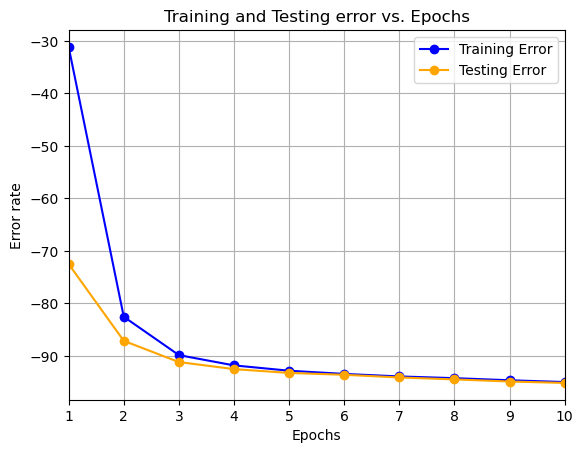

In [10]:
import matplotlib.pyplot as plt

epochs = list(range(1, num_epochs + 1))

plt.plot(epochs, [1-acc for acc in train_accuracy_list], label='Training Error', marker='o', color = "blue")
plt.plot(epochs, [1 - acc for acc in test_accuracy_list], label='Testing Error', marker='o', color = "orange")
plt.title("Training and Testing error vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error rate")
plt.xlim(1,num_epochs)
plt.grid()
plt.legend()

(10000,) (10000,)


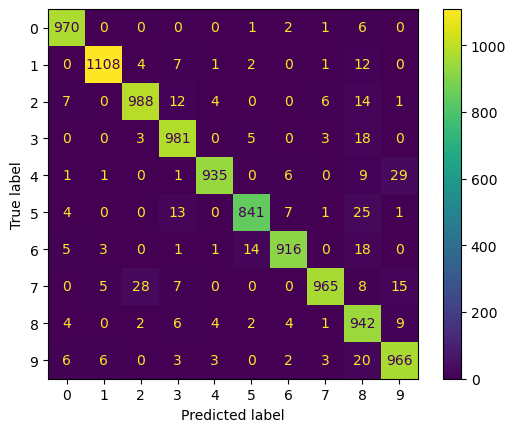

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = []
y_labels = []
model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)        
        y_pred = model(data)        
        _, predicted_labels = torch.max(y_pred, dim=1)
        y_preds.append(predicted_labels.cpu().numpy())  
        y_labels.append(target.cpu().numpy()) 
y_preds = np.concatenate(y_preds)
y_labels = np.concatenate(y_labels)
print(y_preds.shape, y_labels.shape)
cm = confusion_matrix(y_labels, y_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()


Using device: cpu


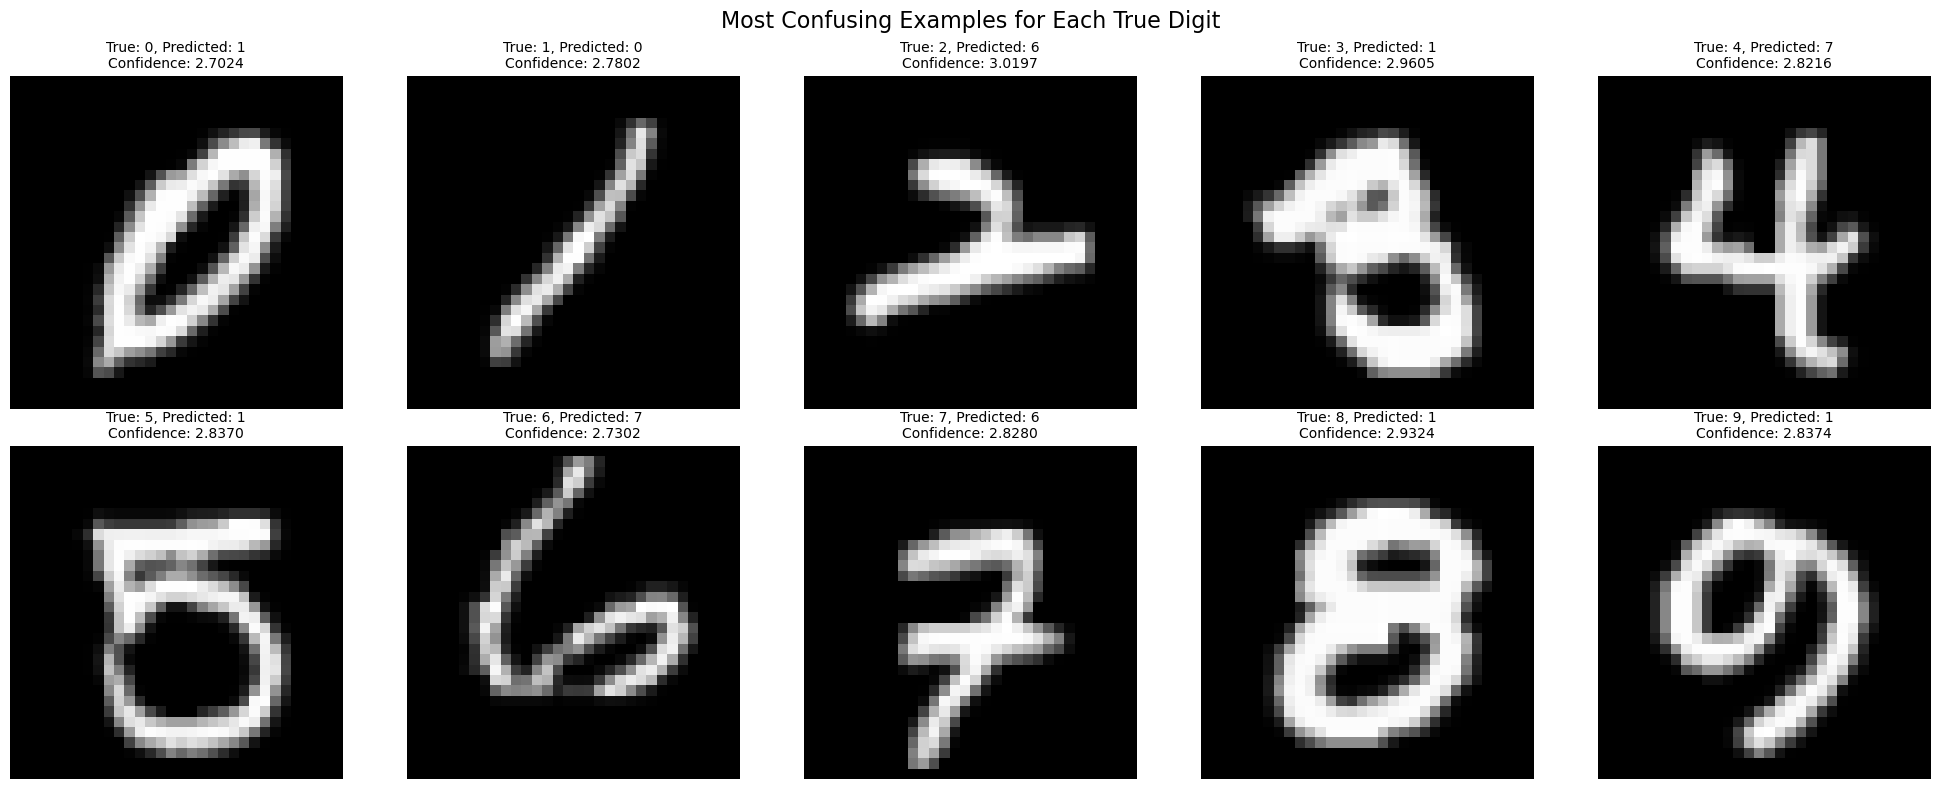

In [16]:
def find_most_confusing_examples(model, test_loader, device):
    model.eval()
    most_confusing = {
        digit: {
            'min_confidence': float('inf'),
            'image': None,
            'true_label': digit,
            'predicted_label': None,
            'rbf_values': None
        } for digit in range(10)
    }

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmin(outputs, dim=1)  # or torch.max, depending on RBF layer design

            for i in range(len(labels)):
                true_label = labels[i].item()
                predicted_label = predicted[i].item()

                if true_label != predicted_label:
                    rbf_values = outputs[i]
                    confidence = rbf_values[predicted_label].item()

                    # Store the most confidently wrong prediction *for the true label*
                    if confidence < most_confusing[true_label]['min_confidence']:
                        most_confusing[true_label] = {
                            'min_confidence': confidence,
                            'image': images[i].cpu(),
                            'true_label': true_label,
                            'predicted_label': predicted_label,
                            'rbf_values': rbf_values.cpu()
                        }

    return most_confusing

def visualize_confusing_examples(most_confusing):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('Most Confusing Examples for Each True Digit', fontsize=16)
    for digit in range(10):
        row = digit // 5
        col = digit % 5
        conf_example = most_confusing[digit]
        if conf_example['image'] is not None:
            axs[row, col].imshow(conf_example['image'].squeeze(), cmap='gray')
            axs[row, col].set_title(
                f'True: {digit}, Predicted: {conf_example["predicted_label"]}\n' +
                f'Confidence: {conf_example["min_confidence"]:.4f}',
                fontsize=10
            )
        else:
            axs[row, col].set_title(f'No Misclassifications\nTrue: {digit}', fontsize=10)
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

most_confusing_examples = find_most_confusing_examples(model, test_loader, device)
visualize_confusing_examples(most_confusing_examples)

In [21]:
print('Train Accuracy at epoch', num_epochs, ': ',train_accuracy_list[num_epochs-1])
print('Test Accuracy at epoch', num_epochs, ': ',test_accuracy_list[num_epochs-1])

Train Accuracy at epoch 10 :  95.95166666666667
Test Accuracy at epoch 10 :  96.12
